
# End-to-End Indicator ML Strategy (BTCUSDT)

Blueprint notebook to transform the provided feature-rich CSVs into a clean feature layer, label future returns, train a baseline ML model, and backtest simple probability-to-position mappings. The main focus is the 1H dataset, with comparison against 4H and 1D.



## 1. Imports & Paths
Load core dependencies and configure the file locations for each timeframe. The 1H file is treated as the primary source while keeping 4H and 1D available for quick comparisons.


In [1]:
import os
import math
import subprocess
from dataclasses import dataclass
from pathlib import Path
from typing import Dict, List, Tuple

import lightgbm as lgb
import numpy as np
import pandas as pd
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

pd.set_option("display.max_columns", None)


def discover_candidate_data_dirs() -> List[Path]:
    """Enumerate plausible data directories, including env overrides and repo root."""
    candidates: List[Path] = []
    seen = set()

    def add(path_like):
        path = Path(path_like).resolve()
        if path in seen:
            return
        seen.add(path)
        candidates.append(path)

    env_dir = os.getenv("DATA_DIR")
    if env_dir:
        add(env_dir)

    cwd = Path.cwd().resolve()
    add(cwd / "data")
    add(cwd / "notebooks" / "data")
    for parent in cwd.parents:
        add(parent / "data")
        add(parent / "notebooks" / "data")

    try:
        repo_root = Path(
            subprocess.check_output(["git", "rev-parse", "--show-toplevel"], text=True).strip()
        )
        add(repo_root / "data")
        add(repo_root / "notebooks" / "data")
    except Exception:
        pass

    return [p for p in candidates if p.exists()]


def resolve_data_path(filename: str) -> Path:
    data_dirs = discover_candidate_data_dirs()
    attempts = []
    for base in data_dirs:
        candidate = base / filename
        attempts.append(candidate)
        if candidate.exists():
            return candidate
    raise FileNotFoundError(
        f"Could not locate data file '{filename}'. Checked: {attempts or ['<no data dirs found>']}. "
        "Set DATA_DIR env var or place the file under one of the listed data directories."
    )


DATA_FILES = {
    "1h": "BINANCE_BTCUSDT.P, 60.csv",
    "4h": "BINANCE_BTCUSDT.P, 240.csv",
    "1d": "BINANCE_BTCUSDT.P, 1D.csv",
}
DATA_PATHS = {tf: resolve_data_path(filename) for tf, filename in DATA_FILES.items()}


In [2]:
def build_feature_layer(path: Path) -> pd.DataFrame:
    path = Path(path)
    if not path.exists():
        raise FileNotFoundError(
            f"Data file not found: {path}. Checked candidate data dirs: {discover_candidate_data_dirs()}."
        )

    df = pd.read_csv(path)
    df = rename_and_filter_columns(df)

    df["time"] = pd.to_datetime(df["time"])
    df = df.sort_values("time").drop_duplicates(subset=["time"])
    df = df.set_index("time")
    df = df.replace([np.inf, -np.inf], np.nan)
    df = df.ffill().bfill()
    df = df.reset_index()

    df["ret_1"] = df["close"].pct_change()
    df["bb_percent"] = (df["close"] - df["bb_lower"]) / (df["bb_upper"] - df["bb_lower"])
    df["bb_width"] = (df["bb_upper"] - df["bb_lower"]) / df["bb_basis"]

    df = df.replace([np.inf, -np.inf], np.nan).ffill().bfill()

    return df


In [3]:

RENAME_MAP = {
    'time': 'time',
    'open': 'open',
    'high': 'high',
    'low': 'low',
    'close': 'close',
    'Volume': 'volume',
    'VWAP': 'vwap',
    'Upper Band #1': 'bb1_upper',
    'Lower Band #1': 'bb1_lower',
    'Basis': 'bb_basis',
    'Upper': 'bb_upper',
    'Lower': 'bb_lower',
    'Up Trend': 'trend_up',
    'Down Trend': 'trend_down',
    'EMA': 'ema_fast',
    'EMA.1': 'ema_slow',
    'Conversion Line': 'ichi_conv',
    'Base Line': 'ichi_base',
    'Lagging Span': 'ichi_lag',
    'Leading Span A': 'ichi_span_a',
    'Leading Span B': 'ichi_span_b',
    'Upper.1': 'channel_upper',
    'Average': 'channel_mid',
    'Lower.1': 'channel_lower',
    'RSI': 'rsi',
    'RSI-based MA': 'rsi_ma',
    'Regular Bullish': 'div_bull',
    'Regular Bullish Label': 'div_bull_label',
    'Regular Bearish': 'div_bear',
    'Regular Bearish Label': 'div_bear_label',
    'Histogram': 'macd_hist',
    'MACD': 'macd',
    'Signal': 'macd_signal',
    'ATR': 'atr',
    'K': 'stoch_k',
    'D': 'stoch_d',
    '%R': 'williams_r',
}

DROP_PATTERNS = [
    'PlotCandle',
]
DROP_EXACT = {'Plot', 'Plot.1', 'Plot.2', 'div_bull_label', 'div_bear_label'}



## 3. Data Loading & Feature Layer Construction
Helper functions to load a timeframe, clean columns, fill gaps, and add a few helper features (returns, Bollinger %B, Bollinger width). The result is the **feature layer** ready for labeling and modeling.


In [4]:
def rename_and_filter_columns(df: pd.DataFrame) -> pd.DataFrame:
    df = df.rename(columns=RENAME_MAP)
    keep_cols = []
    for col in df.columns:
        if any(pattern in col for pattern in DROP_PATTERNS):
            continue
        if col in DROP_EXACT:
            continue
        keep_cols.append(col)
    return df[keep_cols]



## 4. Labeling (Binary Up/Down)
Create a forward return label for a chosen horizon. By default we use 4 bars ahead. `y = 1` when the future return is positive, else `0`.


In [5]:

def add_labels(df: pd.DataFrame, horizon: int = 4) -> pd.DataFrame:
    future_price = df['close'].shift(-horizon)
    df['future_return'] = future_price / df['close'] - 1
    df['y'] = (df['future_return'] > 0).astype(int)
    df = df.dropna(subset=['future_return'])
    return df



## 5. Train/Validation/Test Split (Time-Based)
Use chronological splits (70/15/15). No shuffling is applied to respect temporal order.


In [6]:

@dataclass
class DatasetSplit:
    X_train: pd.DataFrame
    X_val: pd.DataFrame
    X_test: pd.DataFrame
    y_train: pd.Series
    y_val: pd.Series
    y_test: pd.Series
    future_val: pd.Series
    future_test: pd.Series


def time_based_split(df: pd.DataFrame, feature_cols: List[str]) -> DatasetSplit:
    n = len(df)
    train_end = int(n * 0.7)
    val_end = int(n * 0.85)

    train = df.iloc[:train_end]
    val = df.iloc[train_end:val_end]
    test = df.iloc[val_end:]

    X_train, y_train = train[feature_cols], train['y']
    X_val, y_val = val[feature_cols], val['y']
    X_test, y_test = test[feature_cols], test['y']

    return DatasetSplit(
        X_train=X_train,
        X_val=X_val,
        X_test=X_test,
        y_train=y_train,
        y_val=y_val,
        y_test=y_test,
        future_val=val['future_return'],
        future_test=test['future_return'],
    )



## 6. Modeling + Threshold Search
Train a LightGBM classifier inside a scikit-learn pipeline (imputer + scaler). Validation Sharpe on the forward-return horizon is used to pick the best probability threshold for entries.


In [7]:
def compute_sharpe(returns: np.ndarray, periods_per_year: int = 365) -> float:
    ret = np.array(returns)
    if ret.std() == 0:
        return 0.0
    return (ret.mean() * periods_per_year) / (ret.std() * math.sqrt(periods_per_year))


def evaluate_threshold(probs: np.ndarray, future_returns: pd.Series, candidate_thr: List[float]):
    best_sharpe, best_thr = -np.inf, None
    for thr in candidate_thr:
        positions = (probs > thr).astype(int)
        strat_ret = positions * future_returns.values
        sharpe = compute_sharpe(strat_ret)
        if sharpe > best_sharpe:
            best_sharpe, best_thr = sharpe, thr
    return best_thr, best_sharpe


def train_model(split: DatasetSplit, feature_cols: List[str]):
    imputer = SimpleImputer(strategy="median")
    scaler = StandardScaler()

    imputer.fit(split.X_train)
    scaler.fit(imputer.transform(split.X_train))

    def transform(df: pd.DataFrame) -> pd.DataFrame:
        arr = imputer.transform(df)
        arr = scaler.transform(arr)
        return pd.DataFrame(arr, columns=feature_cols, index=df.index)

    X_train = transform(split.X_train)
    X_val = transform(split.X_val)
    X_test = transform(split.X_test)

    model = lgb.LGBMClassifier(
        n_estimators=300,
        learning_rate=0.05,
        max_depth=-1,
        subsample=0.8,
        colsample_bytree=0.8,
        objective="binary",
    )
    model.fit(X_train, split.y_train)

    val_probs = model.predict_proba(X_val)[:, 1]
    candidate_thr = [0.5, 0.55, 0.6, 0.65, 0.7]
    best_thr, best_sharpe = evaluate_threshold(val_probs, split.future_val, candidate_thr)

    test_probs = model.predict_proba(X_test)[:, 1]
    positions_test = (test_probs > best_thr).astype(int)
    strat_ret_test = positions_test * split.future_test.values

    metrics = {
        "val_accuracy": accuracy_score(split.y_val, (val_probs > 0.5).astype(int)),
        "test_accuracy": accuracy_score(split.y_test, (test_probs > 0.5).astype(int)),
        "val_sharpe@best_thr": best_sharpe,
        "test_sharpe@best_thr": compute_sharpe(strat_ret_test),
        "threshold": best_thr,
    }

    reports = {
        "val_report": classification_report(split.y_val, (val_probs > 0.5).astype(int), digits=3),
        "test_report": classification_report(split.y_test, (test_probs > 0.5).astype(int), digits=3),
    }

    processed = {"train": X_train, "val": X_val, "test": X_test}

    return model, metrics, reports, val_probs, test_probs, processed



## 7. End-to-End Runner (Per Timeframe)
Combine all steps for a given timeframe and collect summary metrics. The primary focus is `1h`, with side-by-side stats for `4h` and `1d`.


In [8]:
def run_timeframe(key: str, horizon: int = 4):
    df = build_feature_layer(DATA_PATHS[key])
    df = add_labels(df, horizon=horizon)

    feature_cols = [
        col for col in df.columns
        if col not in {'time', 'y', 'future_return'}
        and not col.startswith('div_')  # drop visual divergence labels
    ]

    split = time_based_split(df, feature_cols)
    model, metrics, reports, val_probs, test_probs, processed = train_model(split, feature_cols)

    summary = {
        "timeframe": key,
        "rows": len(df),
        **metrics,
    }
    return {
        "summary": summary,
        "reports": reports,
        "model": model,
        "feature_cols": feature_cols,
        "split": split,
        "processed_features": processed,
        "val_probs": val_probs,
        "test_probs": test_probs,
    }

results = {tf: run_timeframe(tf) for tf in DATA_PATHS}
summary_df = pd.DataFrame([results[tf]["summary"] for tf in DATA_PATHS])
summary_df


[LightGBM] [Info] Number of positive: 9162, number of negative: 8666
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004226 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8925
[LightGBM] [Info] Number of data points in the train set: 17828, number of used features: 35
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.513911 -> initscore=0.055657
[LightGBM] [Info] Start training from score 0.055657
[LightGBM] [Info] Number of positive: 4863, number of negative: 4675
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001918 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8925
[LightGBM] [Info] Number of data points in the train set: 9538, number of used features: 35
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.509855 -> initscore=0.039426
[LightGBM] [Info] Start training from score 0.039426
[LightGBM] [Info] Num

,timeframe,rows,val_accuracy,test_accuracy,val_sharpe@best_thr,test_sharpe@best_thr,threshold
0,1h,25469,0.549738,0.518451,1.031942,0.189487,0.5
1,4h,13627,0.524462,0.527139,1.793066,0.627287,0.5
2,1d,2269,0.494118,0.483871,3.531258,-0.113110,0.5



### Classification Reports (quick check)
View precision/recall/F1 for each timeframe to understand base discrimination performance.


In [9]:

for tf, res in results.items():
    print(f"=== {tf} ===")
    print(res['reports']['test_report'])


=== 1h ===
              precision    recall  f1-score   support

           0      0.526     0.409     0.460      1916
           1      0.514     0.629     0.566      1905

    accuracy                          0.518      3821
   macro avg      0.520     0.519     0.513      3821
weighted avg      0.520     0.518     0.513      3821

=== 4h ===
              precision    recall  f1-score   support

           0      0.512     0.785     0.619      1003
           1      0.574     0.279     0.376      1042

    accuracy                          0.527      2045
   macro avg      0.543     0.532     0.498      2045
weighted avg      0.543     0.527     0.495      2045

=== 1d ===
              precision    recall  f1-score   support

           0      0.478     0.957     0.638       162
           1      0.588     0.056     0.102       179

    accuracy                          0.484       341
   macro avg      0.533     0.506     0.370       341
weighted avg      0.536     0.484     0.3


## 8. SHAP Explainability (Feature Importance)
Use SHAP to see which indicators drive the `prob_up` predictions. Run on a subset for speed.


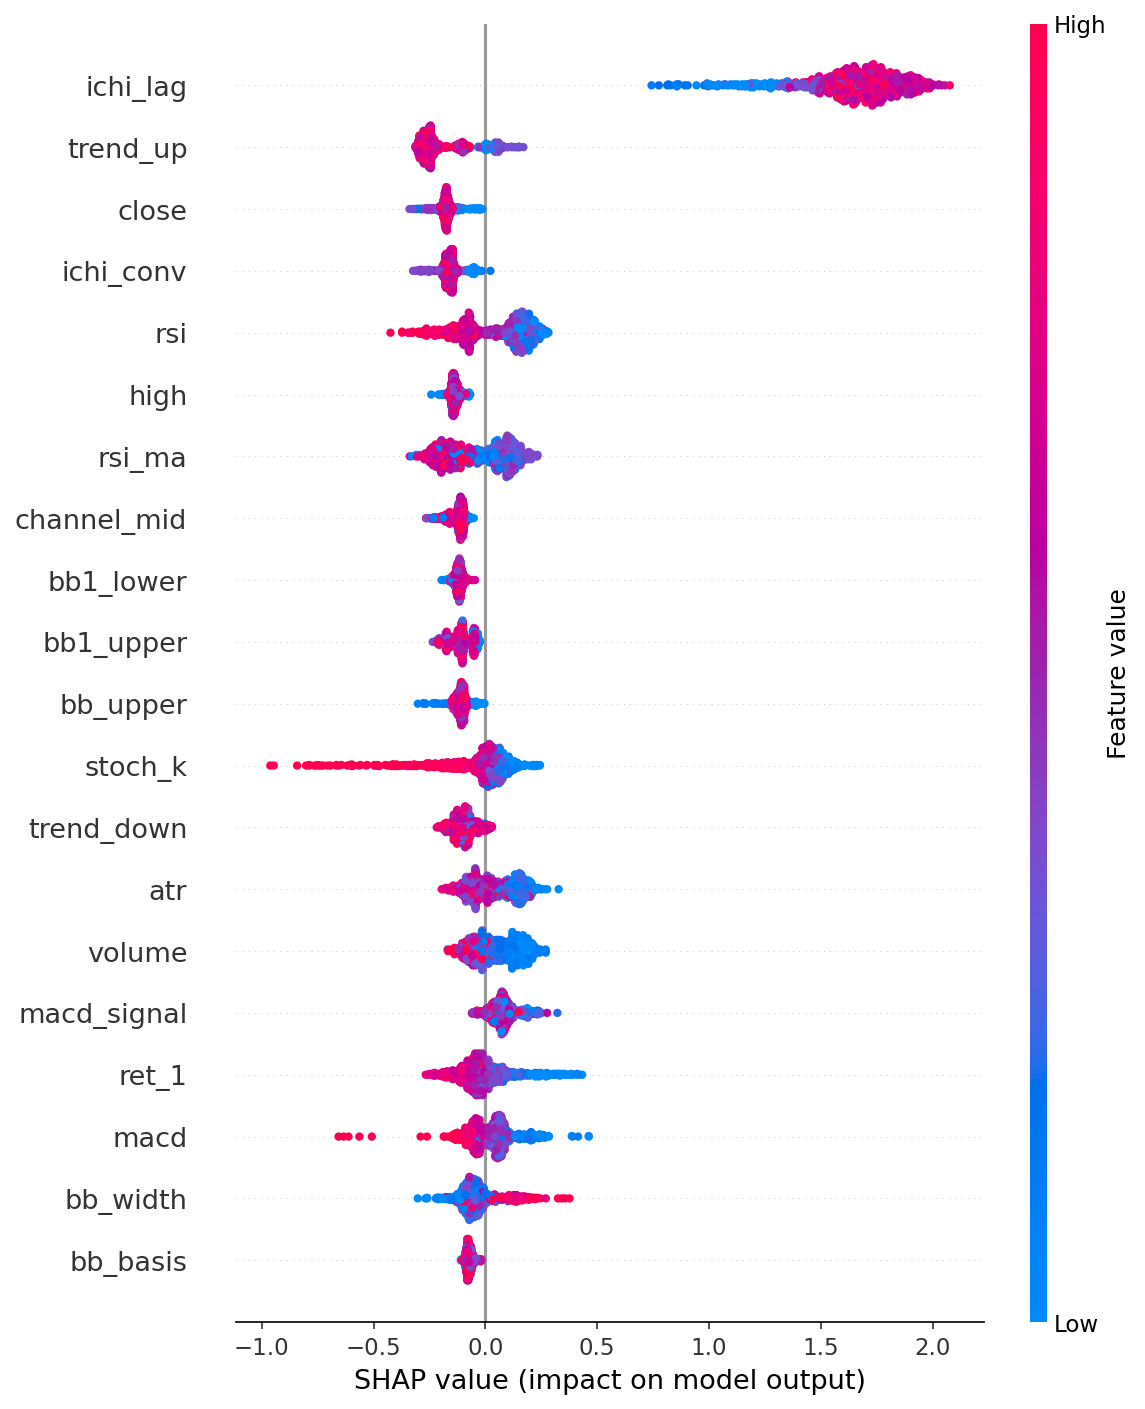

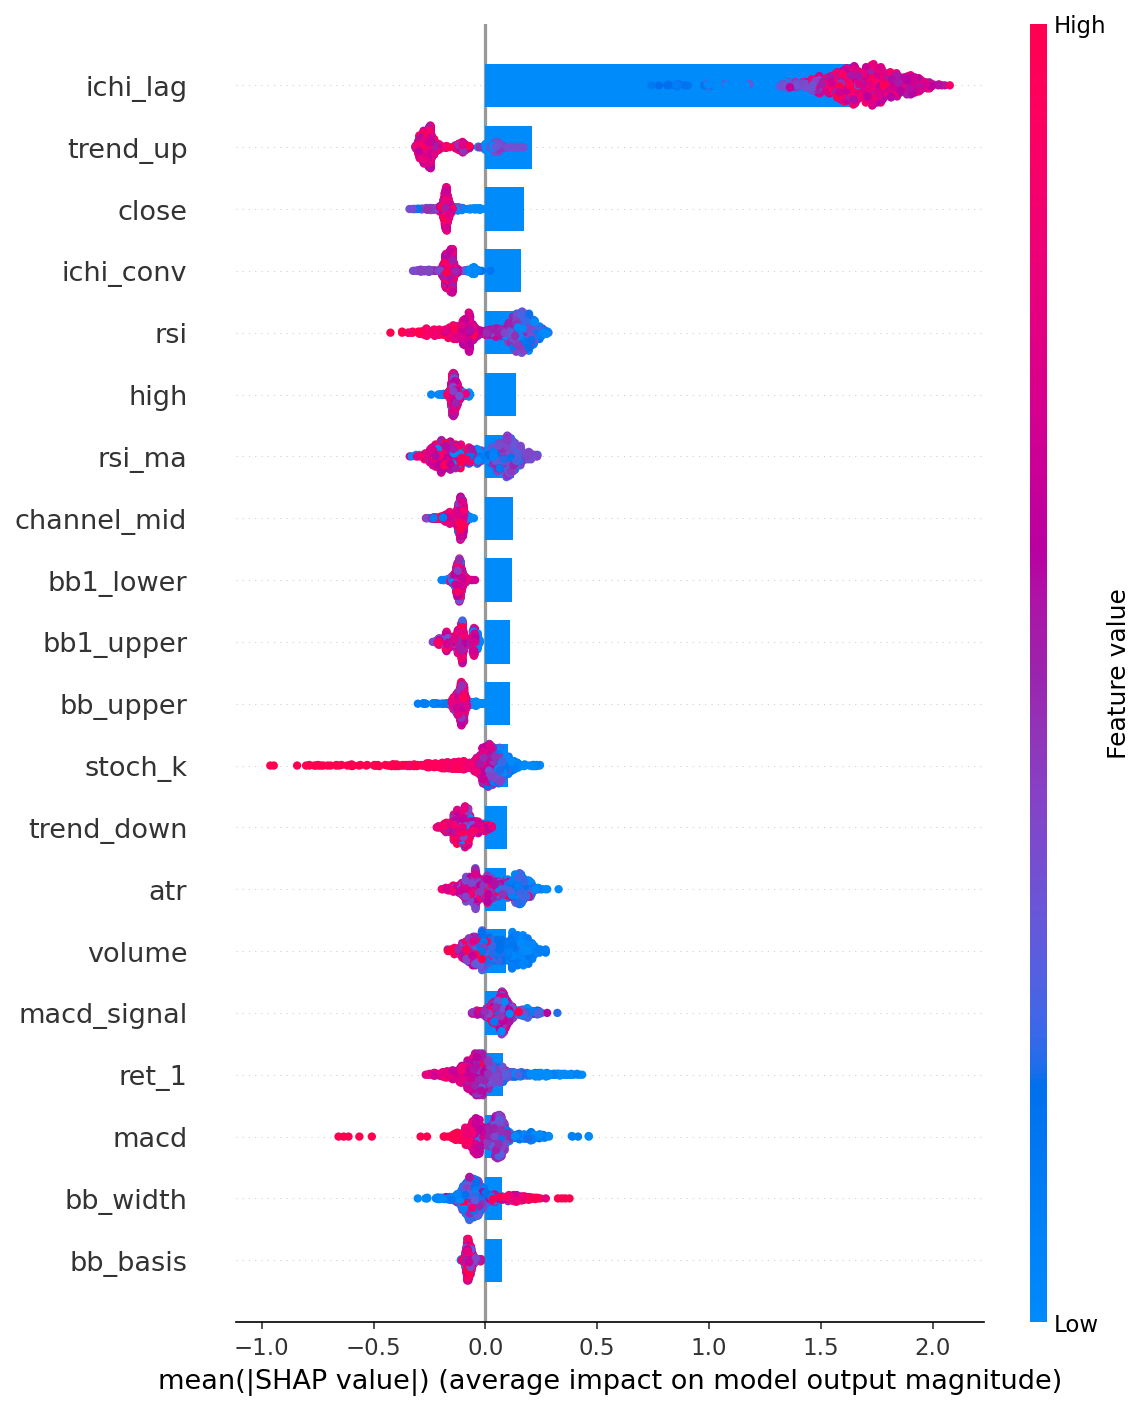

In [10]:
# Uncomment if shap is not available in your environment
# %pip install shap

import io
from pathlib import Path
import matplotlib
matplotlib.use('Agg')
import warnings
from IPython.display import Image, display

# Suppress noisy LightGBM / SHAP output format warnings
warnings.filterwarnings(
    'ignore',
    message='LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray',
    category=UserWarning,
)

IMG_DIR = Path('outputs/shap')
IMG_DIR.mkdir(parents=True, exist_ok=True)

try:
    import shap
    import matplotlib.pyplot as plt
except ModuleNotFoundError:
    print("shap is not installed in this environment. Install with `pip install shap` to view explainability plots.")
else:
    shap.initjs()

    primary = results['1h']
    X_explain = primary['processed_features']['test'].sample(
        n=min(1000, len(primary['processed_features']['test'])), random_state=42
    )
    explainer = shap.TreeExplainer(primary['model'])
    shap_values = explainer.shap_values(X_explain)
    if isinstance(shap_values, list):
        shap_values_class1 = shap_values[1] if len(shap_values) > 1 else shap_values[0]
    else:
        shap_values_class1 = shap_values

    def _save_and_display(fig, filename: str):
        out_path = IMG_DIR / filename
        buf = io.BytesIO()
        fig.savefig(out_path, bbox_inches='tight', dpi=150)
        fig.savefig(buf, format='png', bbox_inches='tight', dpi=150)
        buf.seek(0)
        display(Image(data=buf.read(), format='png', embed=True))

    try:
        shap.summary_plot(shap_values_class1, X_explain, feature_names=primary['feature_cols'], show=False)
        _save_and_display(plt.gcf(), 'shap_beeswarm_1h.png')

        shap.summary_plot(
            shap_values_class1,
            X_explain,
            feature_names=primary['feature_cols'],
            plot_type='bar',
            show=False,
        )
        _save_and_display(plt.gcf(), 'shap_bar_1h.png')
    except Exception as exc:
        print(f"SHAP plotting skipped: {exc}")
    finally:
        plt.close('all')



## 9. Next Steps & Risk Layer
- Apply strategy-specific filters (reversal/trend/volatility) using the `prob_up` outputs and indicators (RSI, bb_percent, macd_hist, EMA stacks, ATR).
- Add risk management: ATR-based SL/TP, max risk per trade, exposure caps.
- Extend to multi-asset or orderbook factors when data is available.


## 10. How to read the outputs

- **What the notebook gives you**
  - `summary_df` (cell 7) → quick table of rows per timeframe plus Sharpe-like metric and accuracy stats for train/val/test. Use this to spot if a timeframe is overfitting (train >> val/test) or too noisy (all metrics ~0.5).
  - Classification reports (cell 8) → precision/recall/F1 per class. Focus on `val` first; test should be close. If you see heavy imbalance, adjust thresholds or class weights.
  - SHAP plots (cell 10) saved to files and displayed inline → top features driving the 1h model. Beeswarm shows directionality (red = high value, blue = low value). Bar plot ranks mean(|SHAP|) importance.

- **How to check data/loading**
  - Cell 3 prints a clear error if a CSV is missing and shows the resolved `PROJECT_ROOT`. If you run elsewhere, set `DATA_ROOT` env var to your folder containing the `BINANCE_BTCUSDT.P, *.csv` files.
  - Ensure the `time` column parses correctly and the index is sorted; the helper already enforces this.

- **How to interpret SHAP**
  - Points on the **right** increase `prob_up`; on the **left** decrease it.
  - Red cluster on the left for `rsi` means overbought reduces the up-probability; blue on the right means oversold supports upside.
  - If a feature you expect (e.g., `trend_up` or `macd_hist`) is missing from top ranks, re-check column renaming or drop rules.

- **What to do next (practical checks)**
  - Re-run cells 7–10 after any data or feature change; keep an eye on validation Sharpe and SHAP ranking stability.
  - If a timeframe underperforms, tweak `horizon`, add/remove features, or raise the prob threshold in cell 6’s search grid.
  - Add simple fee/slippage assumptions in your backtest to see net performance.

- **Save artifacts**
  - Export trained models/scalers if you want to reuse them: `joblib.dump(model, 'outputs/lgbm_1h.pkl')` and keep the feature list from `primary['feature_cols']`.
  - The SHAP images are saved in the working directory; move them to `outputs/` for record-keeping if needed.
